# Introduction


In [1]:
# imports
from __future__ import print_function
from keras import Model
from keras.layers import Input, LSTM, Dense
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

Using TensorFlow backend.


# Problem 1
Execution of machine translation and code reading

### Intro to code
Sequence to sequence example in Keras (character-level).
This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.



### Summary of the algorithm:
- We start with input sequences from a domain (e.g. English sentences)
    and correspding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    Is uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.
        

### Note
**I will be explaining each part of code below**

## Preprocessing

In [2]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra-eng/fra.txt'

### Vectorize Data
In this part, we:
- Read data file and split them by line, each line being one sample
- Each line have the format `<eng-word><fra-word><source>`, so we only take the first two tokens as input and output
- We also make a set of all character from each language (vocab) to use for later encode/decode

In [3]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
lines = open(data_path).read().split('\n')

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)



Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 92
Max sequence length for inputs: 15
Max sequence length for outputs: 59


###  Encoding
- All data is turned into one hot vector
- Decoder data have input and also target data, with target data being +1 time step ahead of the input so that the decoder learns to generate `targets[t+1...]` given `targets[...t]`
- Start character is always `\t`
- This means we will start with `\t` and sequentially predict the next character (in france) given the current character (in english)

In [4]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

## Create and Train Model
Ref: https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/

### Model
**Encoder:**
- Input: one-hot vectorized input english word
  - Latent input is vectorized character
  - No initial input (zero init)
- Output: the output of last layer of LSTM and also its cell state

**Decoder:**
- Input:
  - Output of encoder as initial input
  - Latent input is vectorized decoder input data (also vectorized character)
- Output:
  - LSTM output of each step of lstm (sequence output)

**Predictor**
- Dense layer with softmax activation
- Input is sequence output of decoder, output is one hot representation vector representing prediction

In [5]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 71)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 92)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 256), (None, 335872      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 256),  357376      input_2[0][0]                    
                                                                 lstm_1[0][1]               

In [6]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 10s 1ms/step - loss: 0.8737 - val_loss: 0.9022
Epoch 2/100
8000/8000 [==============================] - 7s 932us/step - loss: 0.6978 - val_loss: 0.7300
Epoch 3/100
8000/8000 [==============================] - 7s 921us/step - loss: 0.5918 - val_loss: 0.6451
Epoch 4/100
8000/8000 [==============================] - 7s 924us/step - loss: 0.5374 - val_loss: 0.6130
Epoch 5/100
8000/8000 [==============================] - 7s 924us/step - loss: 0.4996 - val_loss: 0.5652
Epoch 6/100
8000/8000 [==============================] - 7s 927us/step - loss: 0.4701 - val_loss: 0.5367
Epoch 7/100
8000/8000 [==============================] - 7s 926us/step - loss: 0.4454 - val_loss: 0.5204
Epoch 8/100
8000/8000 [==============================] - 7s 928us/step - loss: 0.4245 - val_loss: 0.5038
Epoch 9/100
8000/8000 [==============================] - 7s 921us/step - loss: 0.4053 - val_loss: 0.4914
Epoch 10

## Inference Prediction

**We construct inference model (encoder and decoder) based on the training model**

The model is the same, the only difference is that we separate encoder and decoder into their own model so we can later easily control and interpret result

In [7]:

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

model = keras.models.load_model("s2s.h5")

## Encoder
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)
encoder_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 71)]        0         
_________________________________________________________________
lstm_1 (LSTM)                [(None, 256), (None, 256) 335872    
Total params: 335,872
Trainable params: 335,872
Non-trainable params: 0
_________________________________________________________________


In [8]:
## Decoder
decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)
decoder_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 92)]   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 256),  357376      input_2[0][0]                    
                                                                 input_3[0][0]              

**Here** we reverse the index so that we can look up the character given its one hot encoding

In [9]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

## Translation of prediction
1. Given the input sequence (a word)
2. Encode it with encoder_model
   - Encoding result is sequence output of LSTM and final cell state
   - The above along with an init value is input for decoder
3. Start with character `\t`, repeatedly use decoder to predict the next character (in france) of the given input
   - Decoder will output the france onehot encoding of a letter given the previous input letter in english 
   - We use this onehot plus the vocabulary dictionary to check which letter in france does the onehot vector represents
   - Then we append the result to the output sentence and continue
4. Stop when output length is long enough or encounter an endline `\n`
5. Return the encoded sentence

In [10]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


## Final Result

In [11]:
for seq_index in range(10):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Va !

-
Input sentence: Go.
Decoded sentence: Va !

-
Input sentence: Go.
Decoded sentence: Va !

-
Input sentence: Hi.
Decoded sentence: Salut !

-
Input sentence: Hi.
Decoded sentence: Salut !

-
Input sentence: Run!
Decoded sentence: File !

-
Input sentence: Run!
Decoded sentence: File !

-
Input sentence: Run!
Decoded sentence: File !

-
Input sentence: Run!
Decoded sentence: File !

-
Input sentence: Run!
Decoded sentence: File !



# Problem 2
Execution of a trained model of image captioning

https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning

### Preparation
For the prep, i have:
- Clone the tutorial code
- Install pytorch (just cpu version)
- Install coco api
- Download the model's weight and also vocabulary
- Test run

### Test pictures

In [12]:
path = "./pytorch-tutorial/tutorials/03-advanced/image_captioning"
%cd $path

f:\Projects\DiveIntoCode\Week 30\pytorch-tutorial\tutorials\03-advanced\image_captioning


<start> a laptop computer sitting on a wooden table . <end>


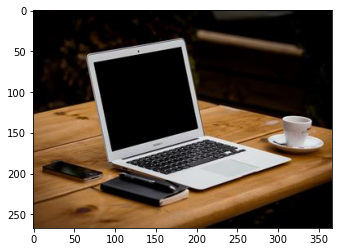

<start> a brown and white dog sitting on a green grass covered field . <end>


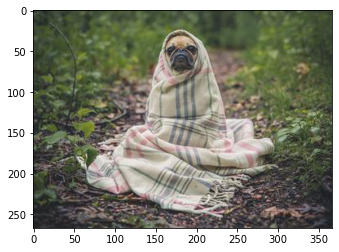

<start> a large group of people on a bridge in the rain . <end>


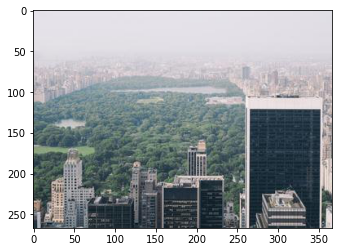

<start> a black and white photo of a glass vase with a clock on it . <end>


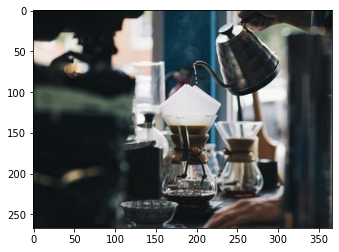

<start> a person is holding a remote control in his hand . <end>


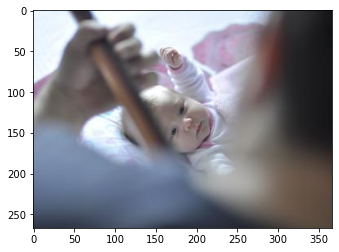

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
for i in range(1,6):
    img = f"png/{i}.jpg"
    %run -i sample.py --image=$img
    plt.imshow(mpimg.imread(img))
    plt.show()

# Problem 3
Investigate what to do if you want to move with Keras

## Note:
I actually think very simple about the conversion between torch and keras initially and try to do it myself, then i got stuck and watched the lecture when i realize that external tool/api is needed for the task! **This is much much more complex than i anticipated**

### Init answer
1. rewrite the model in `model.py`, including:
   1. EncoderRNN
   2. DecoderRNN
2. Make sure that weights `*.pkl` file can be loaded to keras model
    - For this, it seems that keras does not "recommend" picking 
    - But it's still usable through the pickle library
    - Ref: https://medium.com/@maxwellflitton/pickling-keras-models-c10f7c1b99b1

### After watching lecture
- Use external tool such as `pytorch_to_keras`

# Problem 4
Code reading and rewriting

### Torch model

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms 
from PIL import Image
import numpy as np 

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

### Utilities

In [5]:
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                            (0.229, 0.224, 0.225))])
embed_size = 256
hidden_size = 512
num_layers = 1
path = './pytorch-tutorial/tutorials/03-advanced/image_captioning'
encoder_path = f'{path}/models/encoder-5-3000.pkl'
decoder_path = f'{path}/models/decoder-5-3000.pkl'
vocab_path = f'{path}/data/vocab.pkl'

### Torch Model Prep

In [6]:
import pickle 
from build_vocab import Vocabulary
import os

# Load vocabulary wrapper
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

In [7]:
# Build models
encoder = EncoderCNN(embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
encoder = encoder.to(device)
decoder = decoder.to(device)

# Load the trained model parameters
encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

<All keys matched successfully>

### Test Run

In [8]:
image = f'{path}/png/1.jpg'

# Prepare an image
image = load_image(image, transform)
image_tensor = image.to(device)

# Generate an caption from the image
feature = encoder(image_tensor)
sampled_ids = decoder.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)

# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)

<start> a laptop computer sitting on a wooden table . <end>


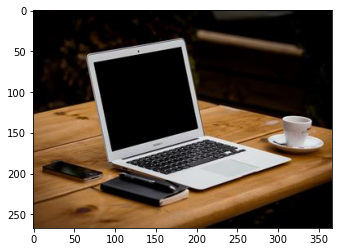

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = f'{path}/png/1.jpg'
# Print out the image_path and the generated caption
print (sentence)
plt.imshow(mpimg.imread(image_path))
plt.show()

### Now that we've seen the model working in parts, let's convert the two parts
- encoder
- decoder

In [10]:
from pytorch2keras.converter import pytorch_to_keras
keras_encoder = pytorch_to_keras(encoder, image_tensor, [image_tensor.shape[1:]], verbose=False)

Custom shapes isn't supported now.
Unable to use `same` padding. Add ZeroPadding2D layer to fix shapes.


In [11]:
keras_encoder.save('keras_caption_encoder');

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: keras_caption_encoder\assets


In [14]:
from tensorflow import keras 
loaded_encoder_keras = keras.models.load_model("keras_caption_encoder")

In [15]:
loaded_encoder_keras.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            [(None, 3, 224, 224) 0                                            
__________________________________________________________________________________________________
1459_pad (ZeroPadding2D)        (None, 3, 230, 230)  0           input_0[0][0]                    
__________________________________________________________________________________________________
1459 (Conv2D)                   (None, 64, 112, 112) 9472        1459_pad[0][0]                   
__________________________________________________________________________________________________
940 (Activation)                (None, 64, 112, 112) 0           1459[0][0]                       
______________________________________________________________________________________________

In [16]:
image = f'{path}/png/1.jpg'
# Prepare an image
image = load_image(image, transform)
test_feature = loaded_encoder_keras(np.array(image))


### This is the output of the keras model

In [17]:
test_feature

<tf.Tensor: shape=(1, 256), dtype=float32, numpy=
array([[ 0.42265168,  1.5188049 , -0.49998993,  0.2199243 , -0.60750914,
        -0.74118805, -0.6065024 , -0.04751028, -0.5013182 , -0.32000938,
         0.44282097, -0.1793105 , -0.15066883,  0.63754445,  0.06504665,
        -0.30541226, -0.17686221, -0.03759497, -0.12514609,  0.71949923,
        -0.8821532 , -0.9201515 , -0.02220193, -2.014041  ,  0.14251356,
        -0.9529408 ,  1.6520526 ,  0.08866471, -0.19053057,  0.20431355,
        -0.36322612, -0.49311787,  0.34472638,  0.13718939, -0.25668216,
         0.12241252, -0.37112343, -1.5787253 ,  0.05556477, -0.49302575,
        -0.07080157,  0.29232708,  0.22183101, -0.0735307 , -0.00926927,
         0.20337889,  0.23714665, -0.6479485 ,  0.06401868,  0.10310712,
        -0.3702467 , -0.34983832,  1.068089  ,  0.00351365, -0.13878864,
         0.61960673,  0.1595881 ,  0.06606975,  0.14318193,  0.98613137,
        -0.3013289 ,  0.62385166,  0.9649308 ,  0.22092974, -0.21431398,
 

### This is output of the torch model

In [18]:
feature

tensor([[ 0.4227,  1.5188, -0.5000,  0.2199, -0.6075, -0.7412, -0.6065, -0.0475,
         -0.5013, -0.3200,  0.4428, -0.1793, -0.1507,  0.6375,  0.0650, -0.3054,
         -0.1769, -0.0376, -0.1251,  0.7195, -0.8822, -0.9202, -0.0222, -2.0140,
          0.1425, -0.9529,  1.6521,  0.0887, -0.1905,  0.2043, -0.3632, -0.4931,
          0.3447,  0.1372, -0.2567,  0.1224, -0.3711, -1.5787,  0.0556, -0.4930,
         -0.0708,  0.2923,  0.2218, -0.0735, -0.0093,  0.2034,  0.2371, -0.6479,
          0.0640,  0.1031, -0.3702, -0.3498,  1.0681,  0.0035, -0.1388,  0.6196,
          0.1596,  0.0661,  0.1432,  0.9861, -0.3013,  0.6239,  0.9649,  0.2209,
         -0.2143, -1.2398, -0.8604, -0.9148,  0.7969, -0.2709, -0.9883, -0.2107,
         -0.4134, -0.9523,  0.1546,  0.2263,  0.5872,  0.4416, -0.0930,  0.0216,
         -0.8313, -0.0253, -0.6589, -0.3719,  0.3502,  0.0319,  0.8517, -0.1232,
         -0.1988,  0.2037,  1.0054, -0.1550,  0.0568, -1.1166,  0.2686, -0.0115,
          0.9405, -0.5763,  

### Conclusion
As can see, the output feature of the encoder is the same, meaning the conversion is success

### Note
- I decided to stop this problem here
- Because converting the decoder is much more challenging due to it `forward` function have multiple arguments and the tool does not specify how to deal with this
- Also, the decoder is related to the complex training of COCO data and the format,... This is why i do not wish to take more time into it
- My idea is only to try and see if converting works, and indeed it did on the encoder

# Problem 5 
Developmental survey

### Translation of JP to ENG
Using problem1 implementation

**We need:**
- Corpus of japanese and matching english words
- Everything else is the same (training, processing, inference,..)

### Advance methods of machine translation?
Im not sure about this topic very much but there's many things
- Rule based method: very expensive and complex since we need to construct rules and such
- Example based: kinda similar to our approach, using A-B example pairs to train
- Statistical method: also uses a bilingual corpus but instead of just learning, they construct a probability model and learn from that
- Neural machine method: currently popular and making much processes, the model structure is similar to our problem 1 

### Generate Image from Text
Ref: https://towardsdatascience.com/generating-synthetic-images-from-textual-description-using-gans-e5963bae0df4

**Some key ideas**
- We have generator and discriminator:
    1. Generator: generate image and make sure that discriminator does not find out
    2. Discriminator: does its best to check if image is real or synthesized

This creates a feedback learning loop in the system

**The generator**
- Just generates image from their embedding
- Does its best against the discriminator

**The discriminator**
- Helps generator to learn by
- Checking if image is real or fake
- Checking if the image generated aligned with the caption